In [36]:
from transformers import ConvNextFeatureExtractor, ConvNextForImageClassification
import torch
import torchvision
from torchvision import transforms
from PIL import Image
from io import BytesIO
import cv2
import requests

image = cv2.imread('cat.png')
response = requests.get("https://image.freepik.com/free-photo/two-beautiful-puppies-cat-dog_58409-6024.jpg")
image = Image.open(BytesIO(response.content))


feature_extractor = ConvNextFeatureExtractor.from_pretrained("facebook/convnext-tiny-224")
model = ConvNextForImageClassification.from_pretrained("facebook/convnext-tiny-224")
model = torchvision.models.resnet18(pretrained=True).eval()


#inputs = feature_extractor(image, return_tensors="pt")

#with torch.no_grad():
#    logits = model(**inputs).logits

# model predicts one of the 1000 ImageNet classes
#predicted_label = logits.argmax(-1).item()
#print(model.config.id2label[predicted_label]),

In [30]:
predicted_label

207

In [37]:
center_crop = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
])

normalize = transforms.Compose([
    transforms.ToTensor(),               # converts the image to a tensor with values between 0 and 1
    transforms.Normalize(                # normalize to follow 0-centered imagenet pixel rgb distribution
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
    )
])
input_img = normalize(center_crop(image)).unsqueeze(0)


In [38]:
from captum.attr import Occlusion
occlusion = Occlusion(model)
strides = (3, 9, 9)               # smaller = more fine-grained attribution but slower
target=207,                       # Labrador index in ImageNet
sliding_window_shapes=(3,45, 45)  # choose size enough to change object appearance
baselines = 0                     # values to occlude the image with. 0 corresponds to gray

attribution_dog = occlusion.attribute(input_img,
                                       strides = strides,
                                       target=target,
                                       sliding_window_shapes=sliding_window_shapes,
                                       baselines=baselines)


target=283,  
                     # Persian cat index in ImageNet
attribution_cat = occlusion.attribute(input_img,
                                        strides = strides,
                                        target=target,
                                        sliding_window_shapes=sliding_window_shapes,
                                        baselines=0)

In [50]:
attribution_dog = np.transpose(attribution_dog.squeeze().cpu().detach().numpy(), (1,2,0))

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

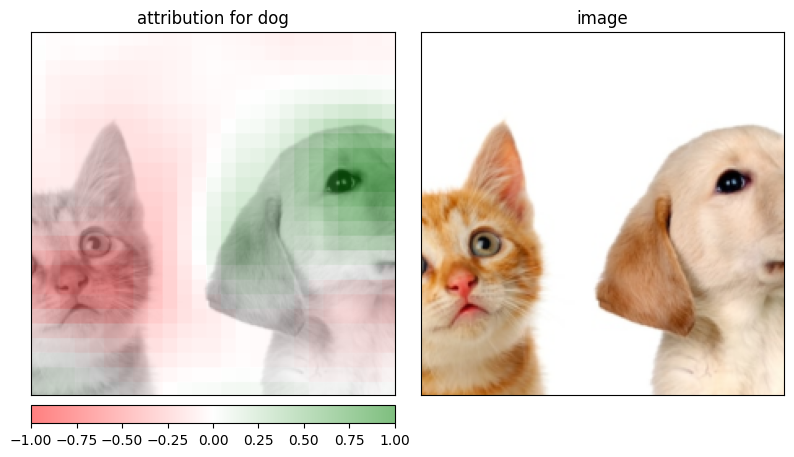

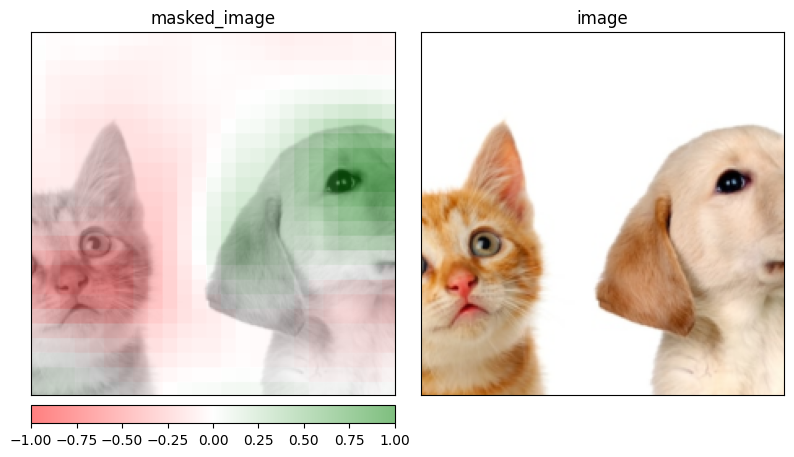

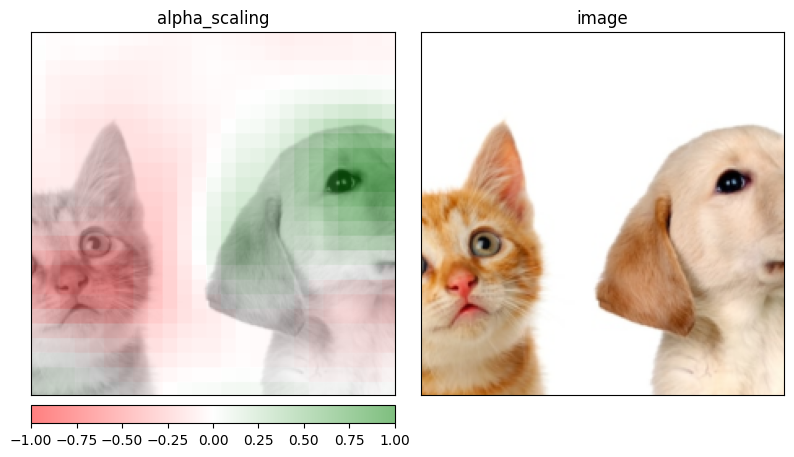

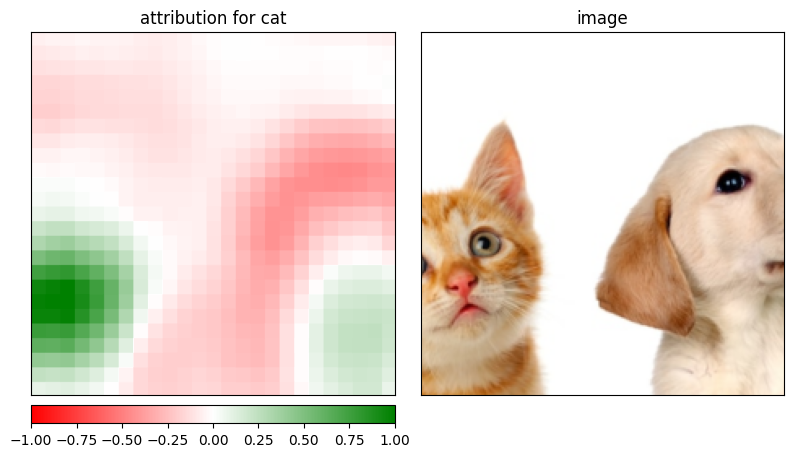

In [55]:
import numpy as np
from captum.attr import visualization as viz

# Convert the compute attribution tensor into an image-like numpy array
#attribution_dog = np.transpose(attribution_dog.squeeze().cpu().detach().numpy(), (1,2,0))

vis_types = ["blended_heat_map", "original_image"]
vis_signs = ["all", "all"] # "positive", "negative", or "all" to show both
# positive attribution indicates that the presence of the area increases the prediction score
# negative attribution indicates distractor areas whose absence increases the score

_ = viz.visualize_image_attr_multiple(attribution_dog,
                                      np.array(center_crop(image)),
                                      vis_types,
                                      vis_signs,
                                      ["attribution for dog", "image"],
                                      show_colorbar = True
                                     )

_ = viz.visualize_image_attr_multiple(attribution_dog,
                                      np.array(center_crop(image)),
                                      vis_types,
                                      vis_signs,
                                      ["masked_image", "image"],
                                      show_colorbar = True
                                     )
_ = viz.visualize_image_attr_multiple(attribution_dog,
                                      np.array(center_crop(image)),
                                      vis_types,
                                      vis_signs,
                                      ["alpha_scaling", "image"],
                                      show_colorbar = True
                                     )
#attribution_cat = np.transpose(attribution_cat.squeeze().cpu().detach().numpy(), (1,2,0))

_ = viz.visualize_image_attr_multiple(attribution_cat,
                                      np.array(center_crop(image)),
                                      ["heat_map", "original_image"],
                                      ["all", "all"], # positive/negative attribution or all
                                      ["attribution for cat", "image"],
                                      show_colorbar = True
                                     )